<a href="https://colab.research.google.com/github/luis1421/monografia_especializacion/blob/main/Entrega_final_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***PRIMERA ENTREGA MONOGRAFIA EACD***

 ## **Titulo:**
 ## **“Valoración cuantitativa de productos a través de procesamiento de lenguaje natural ( NLP)“**

#***INTEGRANTES***

##Luis Felipe Salazar Ucros 

##Diego Stiven Osorio Vélez 

### ¿Por qué queremos hacer esto?
La captura de datos no estructurados mediante la interacción con el cliente es proceso que en general se ha facilitado gracias al streaming data, sin embargo la obtención de dichos datos con su respectiva etiqueta (de necesitarla) resulta complicado en la mayoría de casos, sobretodo en canales diferentes a los propios para los cuales está destinado dejar opiniones o reviews del servicio, tales como las redes sociales, encuestas, etc. Por lo tanto, se hace necesario encontrar una forma de automatizar este proceso, ya que con una etiquetación automática se puede sacar estadísticas en tiempo real, encontrar información relevante para el negocio,atender más rápido las solicitudes y mejorar la experiencia del cliente.

### ¿Qué queremos hacer?

Con base en la opinión que los clientes dejan después de comprar productos en la plataforma se plantea un producto el cuál puede  calcular el nivel de satisfacción del cliente basado en su comentario(opinión) acerca de esta compra, esto permite conocer qué le interesa , qué tan satisfecho se siente con el producto y permite comprender las necesidades para atender las solicitudes más rápidamente.

## Métricas


Para nuestro problema de etiquetas, deseamos reducir los falsos positivos dado que una etiqueta clasificada como positiva  siendo negativa genera que no se le de un seguimiento adecuado al caso.

*   Precisión
*   Recall
  






### **IMPORTACIÓN,LECTURA Y CARGUE DE DATOS**

In [ ]:
# Clonar git que contiene paquetes propios
!git clone https://github.com/luis1421/monografia_especializacion.git

Cloning into 'monografia_especializacion'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 70 (delta 11), reused 56 (delta 7), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [ ]:
# Facilitar importación de paquete
import sys
sys.path.insert(0, 'monografia_especializacion/text_analysis')
print(sys.path)

['monografia_especializacion/text_analysis', '', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
# Instalar paquetes necesarios para las librerias propias
!pip install -r monografia_especializacion/text_analysis/requirements.txt

     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 42 kB 971 kB/s 
     |████████████████████████████████| 4.9 MB 8.6 MB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-1.0.2-py3-none-any.whl size=24393 sha256=adec61db3ce135c48ce0dc59058e6712859a6e99a2dbc6fa88ee4d981974e178
  Stored in directory: /root/.cache/pip/wheels/98/99/eb/bbb9d24a5c526980647efc10336eaaeffcf07749f581111128
Successfully built google-play-scraper


In [ ]:
# Descargas necesarias del paquete nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
## Cargar librerias
import json
import gzip
import pandas as pd
import numpy as np
import tarfile
import csv
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from text_analyzer.document import Document
from text_analyzer.utils import plot_counter, counter_len
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

In [ ]:
# Estilo para las gráficas
sns.set_style("darkgrid")

In [ ]:
# Descargar datos para training
!wget https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz

--2021-11-28 01:06:21--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.231.16
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.231.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘amazon_review_polarity_csv.tgz’

amazon_review_polar 100%[===================>] 656.45M  16.4MB/s    in 42s     

2021-11-28 01:07:04 (15.6 MB/s) - ‘amazon_review_polarity_csv.tgz’ saved [688339454/688339454]



In [ ]:
# Untar
!tar -xf amazon_review_polarity_csv.tgz

In [ ]:
# Cargar 500.000 mil datos y preprocesar labels
path = 'amazon_review_polarity_csv/train.csv'

def get_data(path):
  with open(path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
      yield row
d = get_data(path)

data = []
limit = 0
for i in d:
  if limit == 500000:
    break
  data.append({'sentiment':int(i[0])-1, 'title':i[1], 'review': i[2]}) 
  limit +=1
data[:10]

[{'review': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
  'sentiment': 1,
  'title': 'Stuning even for the non-gamer'},
 {'review': "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
  'sentiment': 1,
  'title': 'The best s

###  **ANALISIS EXPLORATORIO & PROCESAMIENTO DE INFORMACIÓN**

[('book', 264961), ('one', 183545), ('like', 144545), ('would', 121734), ('good', 119283), ('movie', 112699), ('great', 111028), ('read', 103958), ('get', 88774), ('time', 87382)]


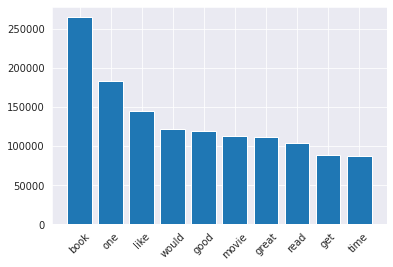

In [ ]:
# Palabras que más se repiten dentro del dataset
df = Document(data, 'review')

print(df.word_counts.most_common(10))
plot_counter(df.word_counts, n_most_common=10)
plt.show()

In [ ]:
# Creamos un dataframe con la lista de diccionarios
df = pd.DataFrame(data)
df

,sentiment,title,review
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
499995,0,Prepare for offence,Ridley's conjecture and supposition swirling a...
499996,1,This is a great song but BUY THE ALBUM.,"Trust me, you'd much rather buy the album than..."
499997,0,What happen to Fram gas filter's Quality ???,I used this same number of Fram filter before ...
499998,0,NO FILTER ON 2003 Hyundai XG350L!!!,There is no fuel filter on this year/make. Tru...


In [ ]:
# Obteniendo información de las variables y su tipo de dato.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  500000 non-null  int64 
 1   title      500000 non-null  object
 2   review     500000 non-null  object
dtypes: int64(1), object(2)
memory usage: 11.4+ MB


In [ ]:
## Exploramos la variable sentiment para ver la proporción
df["sentiment"].value_counts(True)

1    0.505564
0    0.494436
Name: sentiment, dtype: float64

In [ ]:
## Exploramos los datos nulos por columna
for i in df.columns:
  print("La columna {} tiene {} datos nulos de {} lo cual representa un {}% de datos nulos.".format(i,df[i].isnull().sum(),len(df),round(df[i].isnull().sum()/len(df)*100,2))) 

La columna sentiment tiene 0 datos nulos de 500000 lo cual representa un 0.0% de datos nulos.
La columna title tiene 0 datos nulos de 500000 lo cual representa un 0.0% de datos nulos.
La columna review tiene 0 datos nulos de 500000 lo cual representa un 0.0% de datos nulos.


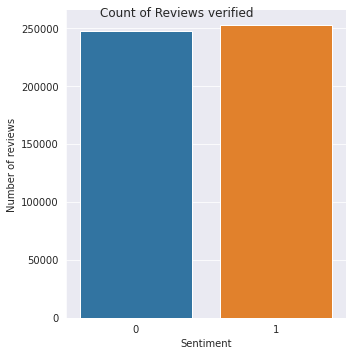

In [ ]:
## Barplot de la variable sentiment
g=sns.catplot(x="sentiment",kind="count",data=df)
g.set_axis_labels("Sentiment","Number of reviews")
g.fig.suptitle('Count of Reviews verified')
plt.show()

In [ ]:
## Ahora creamos un dataframe con las columnas que creemos necesarias para la predicción
df = df[['review','sentiment']]

In [ ]:
# Construir modelo BERT
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
model = build_model()
bert_raw_result = model(tf.constant(['I would not recommend this product']))
print(bert_raw_result)

tf.Tensor([[0.21840145]], shape=(1, 1), dtype=float32)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

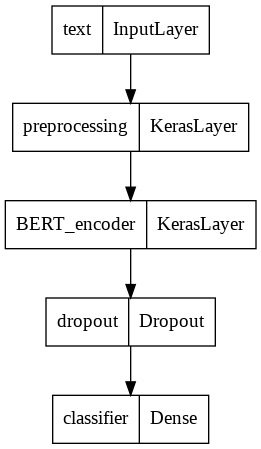

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['review'],df['sentiment'], stratify=df['sentiment'], test_size=0.25,random_state=42)

In [ ]:
print(y_train.mean())
print(y_test.mean())

0.5055653333333333
0.50556


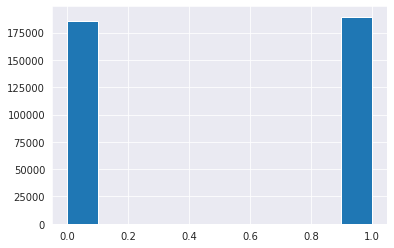

In [ ]:
plt.hist(y_train);

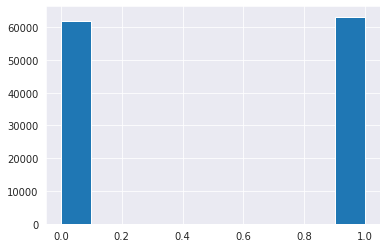

In [ ]:
plt.hist(y_test);

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=1)

11719/11719 [==============================] - 7564s 644ms/step - loss: 0.4559 - accuracy: 0.7886 - precision: 0.7973 - recall: 0.7802


In [ ]:
model.evaluate(X_test, y_test)

3907/3907 [==============================] - 2478s 634ms/step - loss: 0.3904 - accuracy: 0.8317 - precision: 0.8717 - recall: 0.7824


[0.39044830203056335, 0.8317360281944275, 0.871654748916626, 0.782371997833252]

In [ ]:
model_name = 'amazon'
saved_model_path = './{}_bert'.format(model_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./amazon_bert/assets


INFO:tensorflow:Assets written to: ./amazon_bert/assets


In [ ]:
!zip -r /content/amazon_bert.zip /content/amazon_bert

  adding: content/amazon_bert/ (stored 0%)
  adding: content/amazon_bert/saved_model.pb (deflated 92%)
  adding: content/amazon_bert/assets/ (stored 0%)
  adding: content/amazon_bert/assets/vocab.txt (deflated 53%)
  adding: content/amazon_bert/variables/ (stored 0%)
  adding: content/amazon_bert/variables/variables.index (deflated 79%)
  adding: content/amazon_bert/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/amazon_bert/keras_metadata.pb (deflated 84%)


In [ ]:
from google.colab import files
files.download("amazon_bert.zip")

In [ ]:
new_model = tf.keras.models.load_model('amazon_bert')

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[54525,  7280],
       [13753, 49442]])

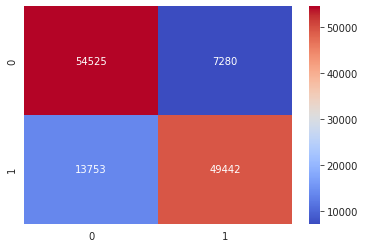

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_predicted), cmap='coolwarm', annot=True, fmt='g');

In [ ]:
# Reporte de métricas
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     61805
           1       0.87      0.78      0.82     63195

    accuracy                           0.83    125000
   macro avg       0.84      0.83      0.83    125000
weighted avg       0.84      0.83      0.83    125000

